[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with DeepSORT Tracker

DeepSORT extends the original SORT algorithm by integrating appearance information through a deep association metric. While maintaining the core Kalman filtering and Hungarian algorithm components from SORT, DeepSORT adds a convolutional neural network (CNN) trained on large-scale person re-identification datasets to extract appearance features from detected objects. This integration allows the tracker to maintain object identities through longer periods of occlusion, effectively reducing identity switches compared to the original SORT. DeepSORT operates with a dual-metric approach, combining motion information (Mahalanobis distance) with appearance similarity (cosine distance in feature space) to improve data association decisions. It also introduces a matching cascade that prioritizes recently seen tracks, enhancing robustness during occlusions. Most of the computational complexity is offloaded to an offline pre-training stage, allowing the online tracking component to run efficiently at approximately 20Hz, making it suitable for real-time applications while achieving competitive tracking performance with significantly improved identity preservation.


## Environment setup

### Configure API keys

To generate DeepSORT features with TIMM, you need to provide your HuggingFace API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Apr 24 10:29:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q inference-gpu
!pip install -q trackers[deepsort]==2.0.0rc2

In [3]:
!pip list | grep supervision
!pip list | grep trackers

supervision                           0.26.0rc6
trackers                              2.0.0rc2


### Download example data

In [4]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [ ]:
from inference import get_model
from trackers import DeepSORTFeatureExtractor, DeepSORTTracker

model = get_model("yolov8m-640")

feature_extractor = DeepSORTFeatureExtractor.from_timm(
    model_name="mobilenetv4_conv_small.e1200_r224_in1k")

tracker = DeepSORTTracker(feature_extractor=feature_extractor)

### Configure annotators

In [6]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=100)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

### Run detection + tracking

In [8]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

SOURCE_VIDEO_PATH = "/content/bikes-1280x720-1.mp4"
TARGET_VIDEO_PATH = "/content/bikes-1280x720-1-result.mp4"

frame_samples = []

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections, frame=frame)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = trace_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, detections.tracker_id)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image

tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

Processing video:   0%|          | 0/388 [00:00<?, ?it/s]

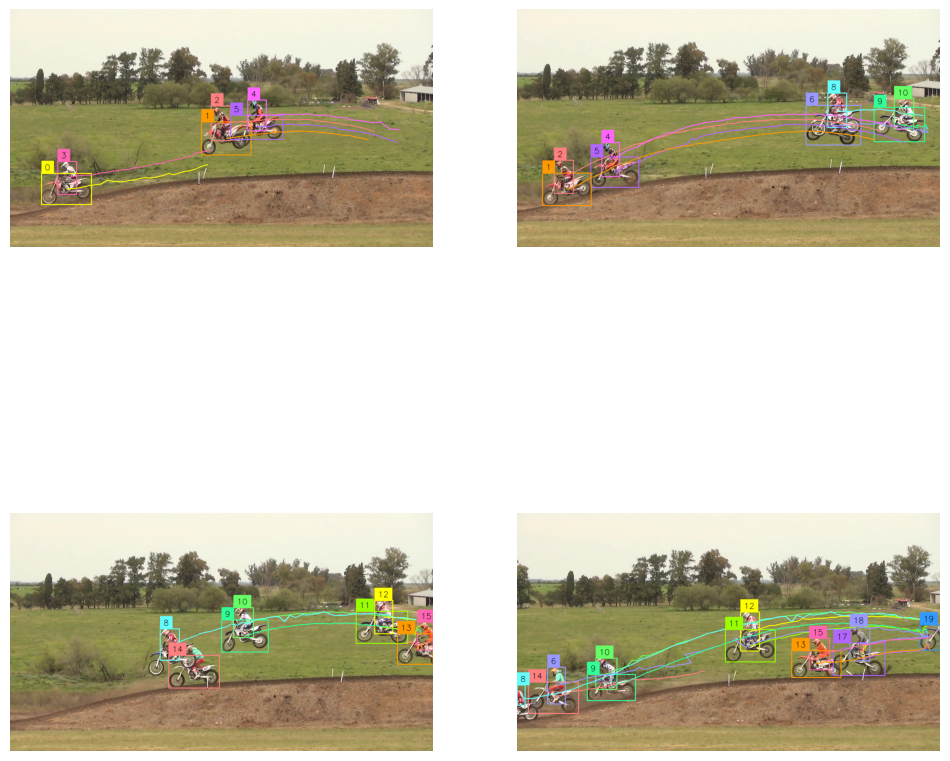

In [9]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

Just combined SORT with an `inference` detector—nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).